In [1]:
from __future__ import absolute_import, division, print_function
import os
import pdb
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
import json
import matplotlib.pyplot as plt
import csv

from pathlib import Path
import dotenv
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 

sys.path.insert(0, PATH_YANGNET)

from task import rules_dict
from network import Model
import tools
from tools_lnd import get_T_inds, plot_N3D, comp_eig_decomp, make_D_use, remove_spines
from tools_lnd import get_model_params, gen_X_from_model_dir, take_names, var_x_epoch, plot_var_x_epoch, plot_var_cumsum

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #Where to save figs
# ##################################################################
fig = 'fig1'
figpath = os.path.join(p_code,'figs',fig,'fig1_BGH')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
# ##################################################################
# #Find right model dir
# ##################################################################
rule_trains = ['delaygo',]
file = 'LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0'
m = os.path.join(p_data,fig,file)


Overwrite sigma_rec with 0.000
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
2024-04-10 23:29:49.950914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Overwrite sigma_rec with 0.000
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt


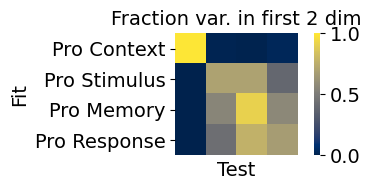

In [4]:
tick_labels = ['Context',
 'Stim',
 'Memory',
 'Response']

sum_dims = 2

var_test_sort = plot_var_x_epoch(m, tick_labels, figpath, n_components = 256, timing_sort=True, sum_dims = sum_dims, 
                                 cmap = 'cividis', fontsize = 14)

# Make csv file for figure
var_test_sort_summed = np.sum(var_test_sort[:, :, :sum_dims], axis=2)

# Save the summed data (var_test_sort_summed) as a separate CSV file
with open(os.path.join(figpath,'1b_left.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(var_test_sort_summed.tolist())  # Convert to list for writing

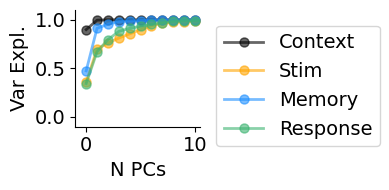

In [5]:
n_dims = plot_var_cumsum(var_test_sort, tick_labels, figpath)

# Make csv file for figure
data_to_save = []

for process_idx in range(len(var_test_sort)):
  # Extract data for the current process (all dimensions)
  process_data = np.cumsum(var_test_sort[process_idx, process_idx, :n_dims], axis=0)
  
  # Combine process label and data into a single list
  data_to_save.append([tick_labels[process_idx]] + process_data.tolist())

# Open the CSV file for writing
with open(os.path.join(figpath,'1b_right.csv'), 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  
  # Write the header row with process labels and dimension labels (0 to n_dims-1)
  header_row = ["Process"] + [f"Dim {i}" for i in range(n_dims)]
  writer.writerow(header_row)
  
  # Write the data for each process
  writer.writerows(data_to_save)

In [6]:
def interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = 'interp_tasks_small_init_mov',
    tol_q = 1e-6,interp = True, cmap_grad = plt.get_cmap('plasma'),cmap_discrete = ['w','k'],
    q_thresh = .001,n_skip_interps=2, rule_axs = 0,ax_labels = [], lil_axes =True, 
    plot_unstable = True,plot_zero_plane = True,color_stim = True,fig_size = 4, fontsize = 20, 
    figpath = [], ruleset = [],alpha_fp = .7,title_y = .9, n_interp = 20,n_trials = 8, 
    stability_thresh = 1,view_ang = [],z_label = []):
    
    fig = plt.figure(figsize=(fig_size,fig_size),tight_layout=True,facecolor='white')
    ax = fig.add_axes([0,0,1,1], projection='3d');
    plt.rcParams.update({'font.size': fontsize})
    al = .5

    rule1 = rules_dict['all'][rule_set[0]]
    rule2 = rules_dict['all'][rule_set[1]]
    rule_str = [rule1,rule2]

    epoch = epoch_set[rule_axs]
    epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
    epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule1)
    epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule2)
    if epoch_name1==epoch_name2:
        epoch_name = epoch_name1
    
    trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
    trial2 = gen_trials_from_model_dir(m,rule_str[1],mode='test',noise_on = False)
    trial2 = same_mov_inds_py3(trial1, trial2) #same_mov_inds
    trial1 = gen_trials_from_model_dir(m,rule_str[0],mode='test',noise_on = False)
    save_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)))
    filename_interp = get_interp_filename(trial1,trial2,epoch_set,t_set)

    for ri in range(2):

        rule = rule_str[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        
        if n_trials==0:
            trial_set = []
        else:
            trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/n_trials))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
        
        if color_stim:
            c_set = np.min(trial.stim_locs[:,[0,2]],axis=1)
            s = np.argwhere(c_set == np.min(trial1.stim_locs[t_set[0],[0,2]]))[0][0]
            c = cmap_grad(np.min(trial1.stim_locs[t_set[0],[0,2]])/max(np.min(trial1.stim_locs[:,[0,2]],axis=1)))
        else:
            c_set = trial.y_loc[-1,:]
            s = np.argwhere(c_set==trial1.y_loc[-1,t_set[0]])[0][0]
            c = cmap_grad(trial1.y_loc[-1,t_set[0]]/max(trial1.y_loc[-1,:]))

        if len(trial_set)>0:
            plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,c_set[trial_set],
               linewidth = 7,linestyle = '-', alpha = .3, markersize = 150, edgecolors = cmap_discrete[ri])
            plot_N3D(ax,x_epoch[[s,],:,:],D_use.T,c_set[trial_set],
               linewidth = 7,linestyle = '-', alpha = 1, markersize = 150, edgecolors = cmap_discrete[ri])

    if interp:
        for step_i in range(n_interp-1,0,-n_skip_interps):#[9, 10, 8, 11, 7, 12, 6, 13, 5, 14, 4, 15, 3, 16, 2, 17, 1, 18, 19, 0]:#
            c = cmap_grad(step_i/n_interp)

            fp_dir = os.path.join(m,script_name,rule_str[0]+'_'+rule_str[1],'tol_q_e_'+str(-np.log10(tol_q)),
                                  filename_interp+'_step_'+str(step_i)+'.npz')
            fp_struct = np.load(fp_dir)
            step_fps = fp_struct['xstar']
            fp_inds = np.where(fp_struct['qstar']<q_thresh)[0]  
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            eig_decomps = comp_eig_decomp(J_xstar)

            for fp_ind in range(len(fp_inds)):

                
                fp = np.dot(sorted_fps[fp_ind,:],D_use)
                
                # stability_metric = alpha_max - np.max(eig_decomps[fp_ind]['evals'].real)
                # stability_metric = np.max((stability_metric,0))
                # stability_metric = np.min((stability_metric,1))
                stability_metric = alpha_fp
                facecolors_3d = c
                facecolors_2d = c
                edgecolors = c#'w'
                al = stability_metric
                
                if np.max(eig_decomps[fp_ind]['evals'])>stability_thresh:
                    if plot_unstable:
                        facecolors_3d = 'w'
                        ax.scatter(fp[0],fp[1],fp[2],s = 100,marker = 'o',edgecolors = edgecolors,
                           facecolors = facecolors_3d,alpha = al)
                else:   
                    s = 100
                    ax.scatter(fp[0],fp[1],fp[2],s = s,marker = 'o',edgecolors = edgecolors,
                           facecolors = facecolors_3d,alpha = al)
    
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()
    ax.set_xlim([x1-.1*abs(x1),x2+.1*abs(x2)])
    ax.set_ylim([y1-.1*abs(y1),y2+.1*abs(y2)])
    [x1,x2] = ax.get_xlim()
    [y1,y2] = ax.get_ylim()


    if ax_labels=='pca_h':
        ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1', labelpad=-5)
        ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2', labelpad=-5)
        ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC3', labelpad=-5)
        save_axes = ax_labels

    if ax_labels=='pca_fp':
        ax.set_xlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC1', labelpad=-5)
        ax.set_ylabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC2', labelpad=-5)
        ax.set_zlabel(r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' FxdPt PC3', labelpad=-5)
        save_axes = ax_labels

    elif len(ax_labels)==3:
        ax.set_xlabel(ax_labels[0], labelpad=0)
        ax.set_ylabel(ax_labels[1], labelpad=0)
        ax.set_zlabel(ax_labels[2],labelpad=0)
        save_axes = 'custom'

    if plot_zero_plane:
        zlabel = 'out_null'
        save_axes = zlabel
        xx, yy = np.meshgrid(np.linspace(x1, x2, num=2), np.linspace(y1, y2, num=2))
        z = xx*0
        ax.plot_surface(xx, yy, z, alpha=0.1)
        ax.set_zlabel(r"$\bf{Output}$"+r'$\cos{\theta}$',labelpad=-10)
        # ax.text(x1, y1, 0, 'Output Null', (1,0,0))
        ax.set_zlim([-1.1,1.1])
        ax.set_zticks([-1,1])

    if len(z_label)>0:
        ax.set_zlabel(z_label,labelpad=0)
        save_axes = z_label

    ax.set_zticks([])
    ax.set_xticks([])
    ax.set_yticks([])
        
    if rule_str[0]==rule_str[1]:
        tit = 'Single Task : '+rule_name1+'\n '+r"$\bf{"+epoch_name1+"}$"+' vs. '+r"$\bf{"+epoch_name2+"}$"+' dynamics' 
        tit_name = ruleset+'_'+rule_name1+'_'+epoch_name1+'_v_'+epoch_name2+'_dynamics_3d'
    else:       
        tit = r"$\bf{"+rule_name1+"}$"+' vs. '+r"$\bf{"+rule_name2+"}$"+ '\n '+epoch_name+' dynamics'
        tit_name = ruleset+'_'+rule_name1+'_v_'+rule_name2+'_'+epoch_name+'_dynamics_3d'   
    plt.title(tit,y = title_y,fontsize  = fontsize)

    if len(view_ang)>0:
        ax.view_init(elev=view_ang[0], azim=view_ang[1])

    ax.dist = 12
    
    fig_fldr = os.path.join(figpath,'interp_fps',ruleset,rule_name_ax+'_'+save_axes)
    if not os.path.exists(fig_fldr):
        os.makedirs(fig_fldr)

    plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
    plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters fro

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:515: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,marker = 'x',


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2998: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:2998: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


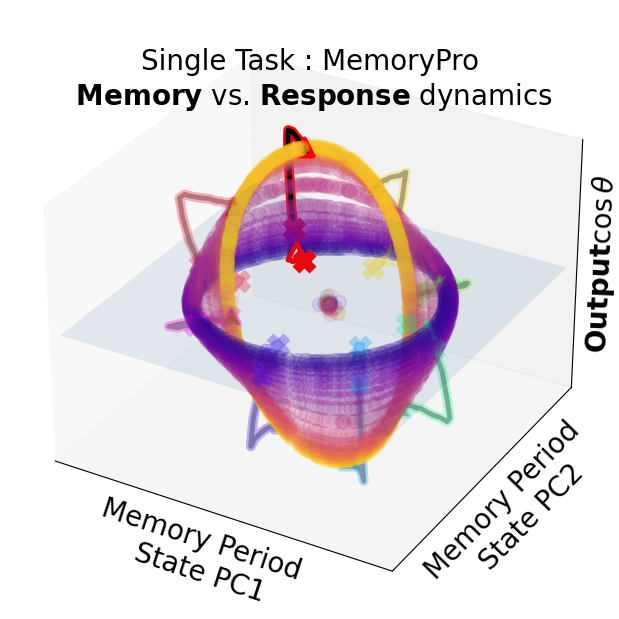

In [7]:
from tools_lnd import same_mov_inds_py3, get_interp_filename, gen_trials_from_model_dir, make_D_use, interp3d

rule_set = [2,2]
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
trial_num = [0,0]
t_set = [0,0]

#make the axes stim related
epoch_set = ['delay1','delay1']

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = -D_use[:,0]
D_use[:,1] = -D_use[:,1]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch_set[rule_axs],rules_dict['all'][rule_set[rule_axs]])
ax_labels = [epoch_name_ax+' Period \n State PC1',
             epoch_name_ax+' Period \n State PC2',
             epoch_name_ax+' Period \n State PC3']

epoch_set = ['delay1','go1']
script_name = 'interp_tasks_small_init_mov'
interp = True
ruleset = '2task_interp'

interp3d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         interp = interp,q_thresh = 1e-6,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,lil_axes =False,color_stim = True,fig_size = 6,figpath = figpath,
         ruleset = ruleset,alpha_fp = .1, stability_thresh = 2, ax_labels = ax_labels)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3854: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3854: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3855: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout,

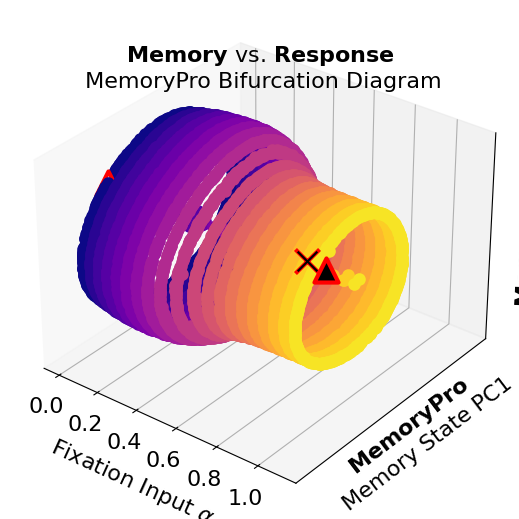

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<

/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3512: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3512: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3513: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout,

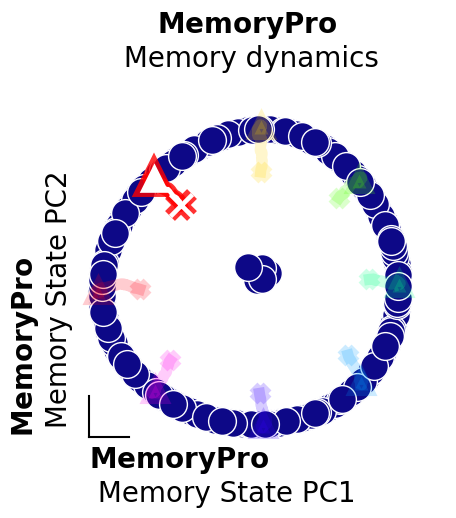

k
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(276, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig1/LeakyRNN_softplus_diag_1_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_0/model.ckpt
8
4
1


/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3512: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/stepnet/tools_lnd.py:3513: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


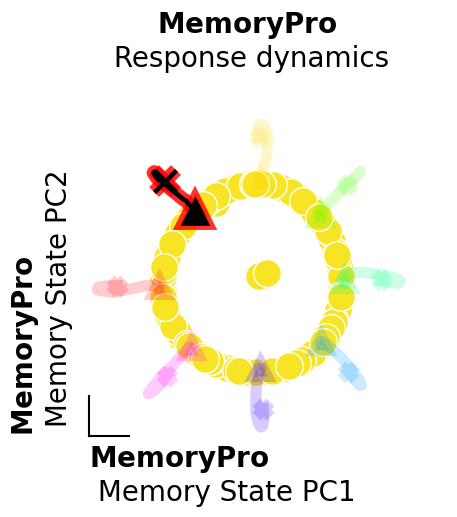

In [8]:
from tools_lnd import make_D_use, interp3d, plot_bifurc_ends, bifurc

fig_size = 5
D_use = np.zeros((256,3))

q_thresh = 1e-6
tol_q = 1e-6
epoch_set = ['delay1','go1']
script_name = 'interp_tasks_small_init_mov'

rule_set = [2,2]
t_set = [0,0]

rule_axs = 0
rule = rules_dict['all'][rule_set[rule_axs]]
rule_str = [rule, rule]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)

rule_axs = 0
epoch = 'delay1'
rule = rules_dict['all'][rule_set[rule_axs]]
ti = t_set[rule_axs]
axs = 'pca_h'
D_use = make_D_use(m,rule,epoch,ti,axs)
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = -D_use[:,0]
D_use[:,1] = -D_use[:,1]

ruleset = '2task_interp'
epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels = [r"Fixation Input $\alpha$",
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2']

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,
         q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,
         n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16,
         figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                       lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2, q_thresh = q_thresh,
                 stability_thresh = 1.05, color_stim = False, figpath = figpath, ruleset = ruleset,
                ax_labels = [ax_labels[1],ax_labels[2]])
